# Investigación de los hechos característicos de los rendimientos de los activos

## Primer hecho: Distribucion no gauseana de los rendimientos

In [1]:
# Establecer requisitos 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns
import scipy.stats as scs
import statsmodels.api as sm
import statsmodels.tsa.api as smt


C:\Users\PC\anaconda3\envs\spyown\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


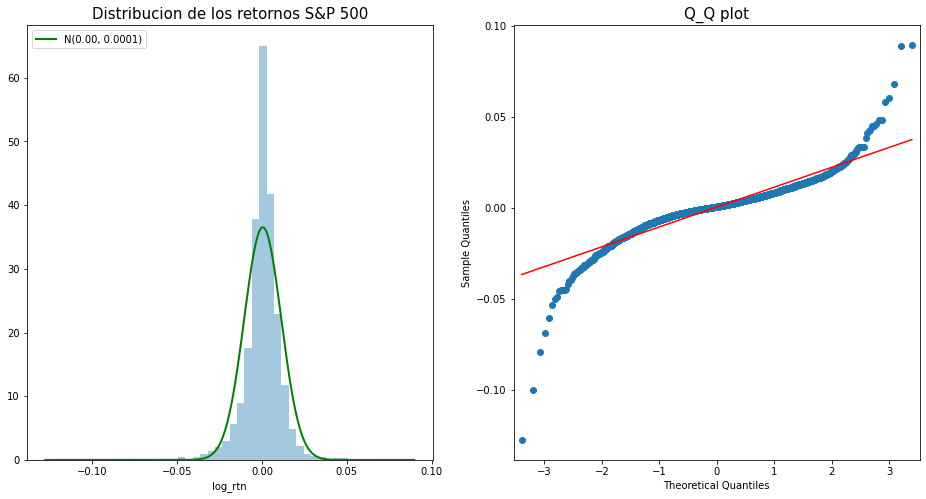

In [2]:
# Obtener indice de yahoo finance
"""Se usara el indice S&P 500 para realizar el ejercicio"""

## Obteniendo datos, seleccion de columna y renombre
df = yf.download("^GSPC", start="2010-01-01", end="2021-08-19", progress=False)
df = df.loc[:,["Adj Close"]].rename(columns={"Adj Close":"adj_close"})

## Calculo de retornos logaritmicos usando precios ajustados
df["log_rtn"] = np.log(df.adj_close / df.adj_close.shift(1))

## Limpia de datos vacios (NaN)
df = df[["adj_close","log_rtn"]].dropna(how="any")

## Calculo de funcion normal de densidad de probabilidad (Probability Density Function PDF)
### Se usa la media, desviacion estandar, y los retornos

r_range = np.linspace(min(df.log_rtn), max(df.log_rtn), num=1000)
mu = df.log_rtn.mean() # media
sigma = df.log_rtn.std() # desviacion estandar
norm_pdf = scs.norm.pdf(r_range, loc=mu, scale=sigma)

##  Grafica de histograma y Q_Q
fig, ax = plt.subplots(1,2, figsize=(16,8)) # 1 fila 2 columnas

### Histograma
sns.distplot(df.log_rtn, kde=False, norm_hist=True, ax=ax[0])
ax[0].set_title("Distribucion de los retornos S&P 500", fontsize=15)
ax[0].plot(r_range, norm_pdf, "g", lw=2, 
            label=f"N({mu:.2f}, {sigma**2:.4f})")
ax[0].legend(loc="upper left")

### Q-Q plot
qq = sm.qqplot(df.log_rtn.values, line="s", ax=ax[1])
ax[1].set_title("Q_Q plot", fontsize=15)

plt.show()


## Test de normalidad de jarquebera


In [3]:
jb_test = scs.jarque_bera(df.log_rtn.values)
print("-"*10+"Estadisticas descriptivas"+10*"-")
print("Rango de datos:\t", min(df.index.date),"-",max(df.index.date))
print("Numero de observaciones:\t", df.shape[0])
print(f"Media\t\t\t\t{df.log_rtn.mean():.4f}")
print(f"Valor minimo:\t\t\t{df.log_rtn.min():.4f}")
print(f"Valor maximo:\t\t\t{df.log_rtn.max():.4f}")
print(f"Desviacion estandar:\t\t{df.log_rtn.std():.4f}")
print(f"Asimetria (skewnes):\t\t{df.log_rtn.skew():.4f}")
print(f"Kurtosis:\t\t\t{df.log_rtn.kurtosis():.4f}")
print(f"Estadistico Jarquebera:\t{jb_test[0]:.2f} con p-value:{jb_test[1]:.2f}")


----------Estadisticas descriptivas----------
Rango de datos:	 2010-01-05 - 2021-08-18
Numero de observaciones:	 2926
Media				0.0005
Valor minimo:			-0.1277
Valor maximo:			0.0897
Desviacion estandar:		0.0109
Asimetria (skewnes):		-0.8614
Kurtosis:			16.3310
Estadistico Jarquebera:	32757.88 con p-value:0.00


## Segundo hecho: Agrupacion de la volatilidad

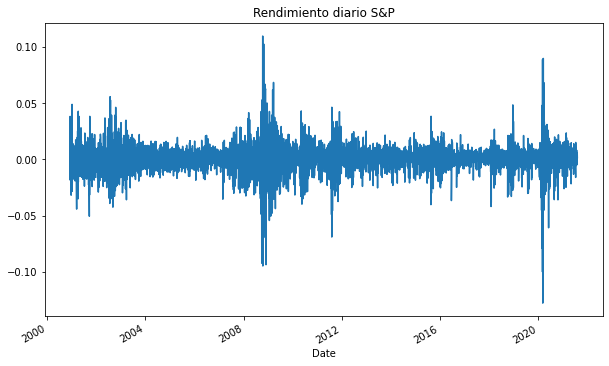

In [4]:
import numpy as np
import pandas as pd
import yfinance as yf

import matplotlib.pyplot as plt

# Se trabajara con los rendimientos logaritmicos
df = yf.download("^GSPC", start="2000-12-01", end="2021-08-14", progress=False)

# Obteniendo columna cierre ajustado
df = df.loc[:,["Adj Close"]]
df.rename(columns={"Adj Close":"adj_close"}, inplace=True)

# Calculo de rendimiento logaritmico
df["log_rtn"] = np.log(df.adj_close/df.adj_close.shift(1))
# >> ELIMINANDO VALORES 'NA' 
df.dropna(how = 'any', inplace = True)

df.log_rtn.plot(title="Rendimiento diario S&P", figsize=(10,6))
plt.show()


## Tercer hecho: Ausencia de autocorrelacion en los rendimientos

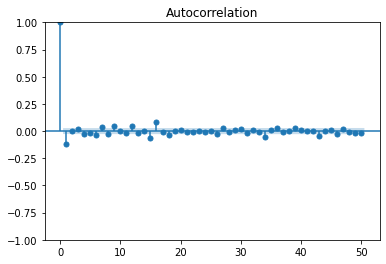

In [5]:
#  Ausencia de autocorrelación en los rendimientos
# ->Definiendo parametros para crear graficos de autocorrelacion.

N_LAGS = 50 
SIGNIFICANCE_LEVEL = 0.05 # Nivel de significancia

# ->Grafica de la funcion de autocorrelacion
acf = smt.graphics.plot_acf(df.log_rtn, lags=N_LAGS, alpha=SIGNIFICANCE_LEVEL)
plt.show()

**Conclusiones**

Sólo unos pocos valores se sitúan fuera del intervalo de confianza (no miramos el lag 0) y pueden considerarse estadísticamente significativos. Podemos suponer que hemos comprobado que no hay autocorrelación en la serie de rendimientos logarítmicos.

## Cuarto hecho: Autocorrelacion pequeña y decreciene
**Presentada en los retornos cuadrados/absolutos**

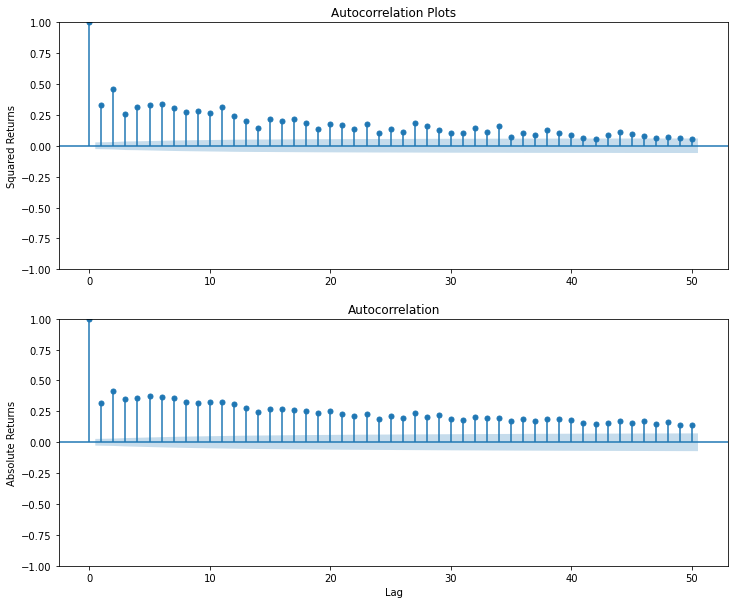

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

# ->Grafica de la funcion de autocorrelacion retornos cuadrados
smt.graphics.plot_acf(df.log_rtn ** 2, lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[0])
ax[0].set(title='Autocorrelation Plots',
          ylabel='Squared Returns')

# ->Grafica de la funcion de autocorrelacion retornos absolutos
smt.graphics.plot_acf(np.abs(df.log_rtn), lags=N_LAGS, 
                      alpha=SIGNIFICANCE_LEVEL, ax = ax[1])
ax[1].set(ylabel='Absolute Returns',
          xlabel='Lag')

# plt.tight_layout()
# plt.savefig('images/ch1_im14.png')
plt.show()

## Quinto hecho: Efecto leverage o apalancamiento 
Investigacion de existencia de apalancamiento

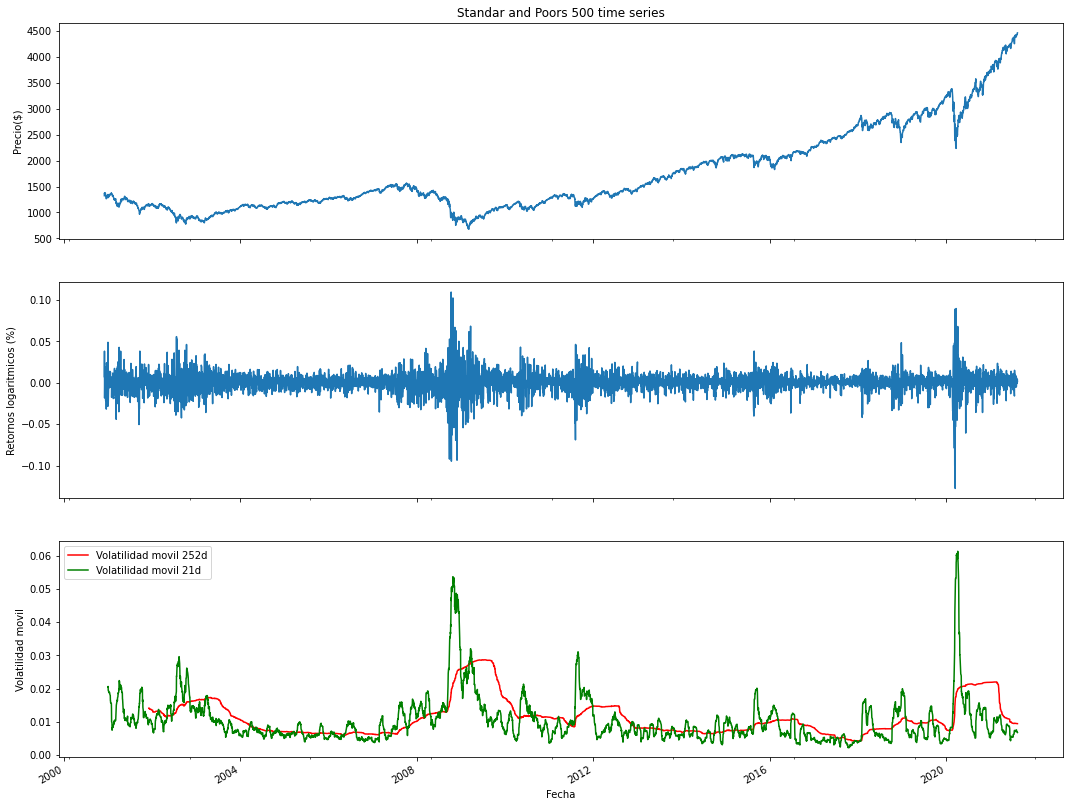

In [7]:
# Calcular las medidas de volatilidad como desviaciones estándar móviles

## Se inserta las medidas de volatilidad en el data frame
df['moving_std_252'] = df[['log_rtn']].rolling(window=252).std()
df['moving_std_21'] = df[['log_rtn']].rolling(window=21).std()

## Impresion de las series
fig, ax = plt.subplots(3,1, figsize=(18,15), sharex=True)

## Definiendo parametros del primer grafico
df.adj_close.plot(ax=ax[0])
ax[0].set(title="Standar and Poors 500 time series", ylabel="Precio($)")

## Definicion parametros del segundo grafico
df.log_rtn.plot(ax=ax[1])
ax[1].set(ylabel='Retornos logaritmicos (%)')

## Parametros de las medidas de volatilidad
df.moving_std_252.plot(ax=ax[2], color="r", label="Volatilidad movil 252d")
df.moving_std_21.plot(ax=ax[2], color="g", label="Volatilidad movil 21d")

ax[2].set(ylabel="Volatilidad movil", xlabel="Fecha")
ax[2].legend()
plt.show()


**Conclusiones**

Este hecho establece que la mayoría de las medidas de la volatilidad de un activo están correlacionadas negativamente con sus rendimientos, podemos observar un patrón de aumento de la volatilidad cuando los precios bajan y de disminución de la volatilidad cuando están subiendo.

### Otro medodo para investigacion de efecto leverage

In [10]:
#1 Descarga y preprocesamiento de los precios indices: S&P 500 y VIX 
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = yf.download(['^GSPC', '^VIX'], 
                 start='1997-01-01', 
                 end='2020-12-31',
                 progress=False)
df = df[['Adj Close']] 
print(df)
df.columns = df.columns.droplevel(0)
df = df.rename(columns={'^GSPC': 'sp500', '^VIX': 'vix'})

## Calculo de los rendimientos logaritmicos
df["log_rtn"] = np.log(df.sp500 / df.sp500.shift(1))
df["vol_rtn"] = np.log(df.vix / df.vix.shift(1))
df.dropna(how="any", axis=0, inplace=True)

df.head(4)

              Adj Close           
                  ^GSPC       ^VIX
Date                              
1997-01-02   737.010010  21.139999
1997-01-03   748.030029  19.129999
1997-01-06   747.650024  19.889999
1997-01-07   753.229980  19.350000
1997-01-08   748.409973  20.240000
...                 ...        ...
2020-12-23  3690.010010  23.309999
2020-12-24  3703.060059  21.530001
2020-12-28  3735.360107  21.700001
2020-12-29  3727.040039  23.080000
2020-12-30  3732.040039  22.770000

[6040 rows x 2 columns]


,sp500,vix,log_rtn,vol_rtn
Date,,,,
1997-01-03,748.030029,19.129999,0.014842,-0.099909
1997-01-06,747.650024,19.889999,-0.000508,0.038959
1997-01-07,753.229980,19.350000,0.007436,-0.027525
1997-01-08,748.409973,20.240000,-0.006420,0.044968


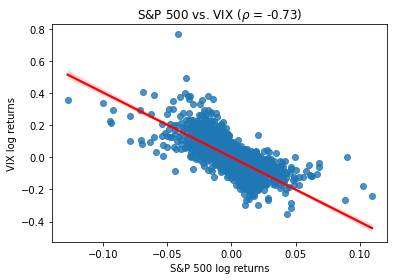

In [12]:
#2 Traza un gráfico de dispersión 
# con los rendimientos en los ejes y ajusta una línea de regresión para 
# identificar la tendencia:
# ---
import seaborn as sns

corr_coeff = df.log_rtn.corr(df.vol_rtn) # <- coeficiente de correlacion

ax = sns.regplot(x='log_rtn', y='vol_rtn', data=df, 
                 line_kws={'color': 'red'})
ax.set(title=f'S&P 500 vs. VIX ($\\rho$ = {corr_coeff:.2f})',
       ylabel='VIX log returns',
       xlabel='S&P 500 log returns')
plt.show()